## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN,LSTM,GRU, Dense,Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
import geopandas as gpd
from shapely.geometry import Point
import folium
from sklearn.metrics import accuracy_score
import random
from shapely.geometry import LineString, box

In [2]:
drive.mount('/content/drive')
# %cd '/content/drive/MyDrive/T5/Capstone_Project_T5'

Mounted at /content/drive


#Load Data

In [3]:
gdf = gpd.read_file('/content/drive/MyDrive/T5/Capstone_Project_T5/data 6 month/merged_6month_update.gpkg')
gdf.set_index('time_series', inplace=True)
gdf.sort_index(inplace=True)

# Exploratory Data Analysis (EDA)

In [4]:
# if gdf['time_series_left'].equals(gdf['time_series_right']):
#     print("OK")

In [5]:
if gdf['street_name_left'].equals(gdf['street_name_right']):
    print("OK")

In [6]:
gdf.head(5)

,accident_id,street_name_left,number_of_cars_involved,accident_reason,number_of_injured,traffic_id,time_series_right,street_name_right,weather,number_of_cars,average_car_speed,traffic_status,day_name,date,point_geometry_wkt,geometry
time_series,,,,,,,,,,,,,,,,
2023-01-01 06:00:00,0,طريق خريص,3,Road Conditions,0,177,2023-01-01 06:00:00,طريق خريص,Clear,14,107.12,Light,Sunday,None,POINT (46.8123571 24.7456475),"LINESTRING (46.81213 24.7455, 46.81236 24.74565)"
2023-01-01 11:00:00,1,خريص,3,Speeding,0,2329,2023-01-01 11:00:00,خريص,Cloudy,49,47.21,Moderate,Sunday,None,POINT (46.794121 24.7343353),"LINESTRING (46.79363 24.73404, 46.79412 24.73434)"
2023-01-01 14:00:00,2,خريص,2,Road Conditions,0,3732,2023-01-01 14:00:00,خريص,Rainy,42,35.66,Heavy,Sunday,None,POINT (46.7826574 24.7277724),"LINESTRING (46.78266 24.72777, 46.7817 24.72718)"
2023-01-01 16:00:00,3,خريص,2,Road Conditions,0,4768,2023-01-01 16:00:00,خريص,Clear,64,24.84,Heavy,Sunday,None,POINT (46.8631253 24.7938616),"LINESTRING (46.86313 24.79386, 46.86064 24.79053)"
2023-01-02 06:00:00,6,طريق خريص,2,Road Conditions,3,6198,2023-01-02 06:00:00,طريق خريص,Foggy,34,92.87,Light,Monday,None,POINT (46.9924938 24.9288979),"LINESTRING (46.97912 24.90795, 46.98097 24.909..."


In [7]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
DatetimeIndex: 1038 entries, 2023-01-01 06:00:00 to 2023-06-30 23:00:00
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   accident_id              1038 non-null   int64         
 1   street_name_left         1038 non-null   object        
 2   number_of_cars_involved  1038 non-null   int64         
 3   accident_reason          1038 non-null   object        
 4   number_of_injured        1038 non-null   int64         
 5   traffic_id               1038 non-null   int64         
 6   time_series_right        1038 non-null   datetime64[ms]
 7   street_name_right        1038 non-null   object        
 8   weather                  1038 non-null   object        
 9   number_of_cars           1038 non-null   int64         
 10  average_car_speed        1038 non-null   float64       
 11  traffic_status           1038 non-null   object    

In [8]:
gdf.describe()

,accident_id,number_of_cars_involved,number_of_injured,traffic_id,time_series_right,number_of_cars,average_car_speed
count,1038.000000,1038.000000,1038.000000,1038.000000,1038,1038.000000,1038.000000
mean,518.500000,2.111753,0.586705,470484.537572,2023-03-31 23:54:54.797000,60.485549,46.397341
min,0.000000,1.000000,0.000000,177.000000,2023-01-01 06:00:00,10.000000,5.170000
25%,259.250000,1.000000,0.000000,217494.250000,2023-02-11 20:15:00,36.000000,32.810000
50%,518.500000,2.000000,0.000000,479888.500000,2023-04-02 23:30:00,49.000000,43.955000
75%,777.750000,2.000000,0.000000,702467.250000,2023-05-15 13:15:00,87.000000,59.247500
max,1037.000000,10.000000,5.000000,946019.000000,2023-06-30 23:00:00,150.000000,119.230000
std,299.789093,1.275478,1.340597,274097.163084,NaN,31.496602,22.653578


In [9]:
gdf.isnull().sum()

,0
accident_id,0
street_name_left,0
number_of_cars_involved,0
accident_reason,0
number_of_injured,0
traffic_id,0
time_series_right,0
street_name_right,0
weather,0
number_of_cars,0


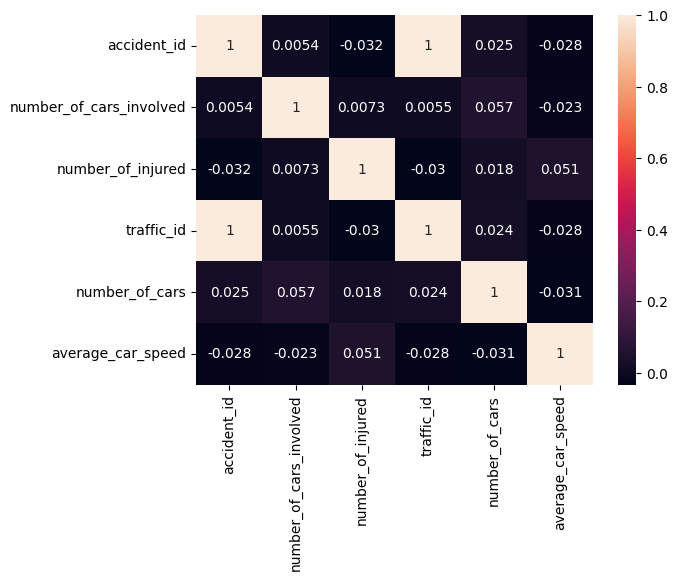

In [10]:
num_columns = gdf.select_dtypes(include=['number','float64'])
sns.heatmap(num_columns.corr(),annot=True)
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future ve

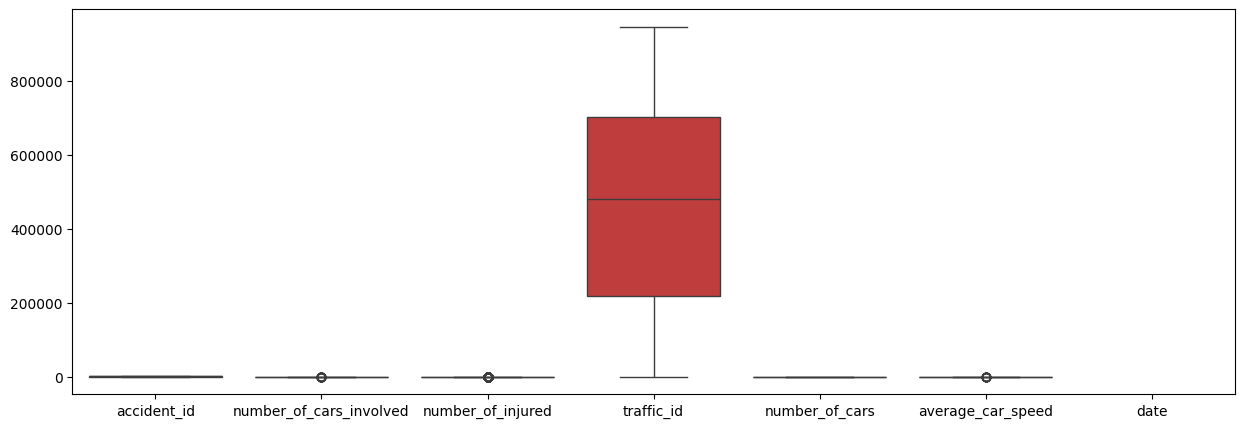

In [11]:
plt.figure(figsize=(15, 5))
sns.boxplot(gdf)
plt.show()

# Data Preprocessing

### Drop Unsecseary Columns

In [12]:
gdf.drop(columns=['accident_id','traffic_id','date','time_series_right','point_geometry_wkt',
                  'street_name_left','street_name_right','weather','day_name'], inplace=True)

### Label Encoder

In [13]:
label_encode = LabelEncoder()
gdf['accident_reason'] = label_encode.fit_transform(gdf['accident_reason'])
gdf['traffic_status'] = label_encode.fit_transform(gdf['traffic_status'])

In [14]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    for col in gdf.columns:
     gdf = remove_outliers(gdf,gdf.col)

In [15]:
gdf.drop_duplicates(inplace=True)
gdf.duplicated().sum()

0

## Plot Data

<Axes: >

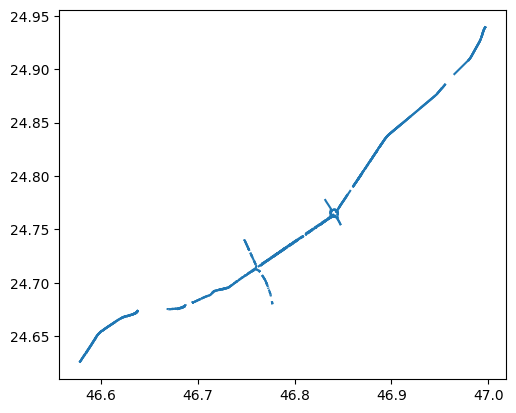

In [16]:
gdf.plot()


## Feature Engineering


### Manuplate with geometry column

In [17]:
def extract_coordinates(geom):
    """Extracts coordinates from a LINESTRING geometry."""
    if geom.geom_type == 'LineString':
        # Get the coordinates of the LineString
        coords = list(geom.coords)
        # Extract latitude and longitude for the start and end points
        latitude_x, longitude_x = coords[0]  # Start point
        latitude_y, longitude_y = coords[1]  # End point
        return latitude_x, longitude_x, latitude_y, longitude_y
    else:
        # Handle cases where geometry is not a LineString (e.g., Point)
        return None, None, None, None  # Or raise an exception

# Apply the function to the 'geometry' column
gdf[['latitude_x', 'longitude_x', 'latitude_y', 'longitude_y']] = gdf['geometry'].apply(lambda geom: pd.Series(extract_coordinates(geom)))

# Save geometry and traffic status to draw map
gdf_map = pd.DataFrame({
    'traffic_status': gdf['traffic_status'],
    'geometry': gdf['geometry'],
    })
# Drop the original 'geometry' column
gdf.drop(columns=['geometry'], inplace=True)

## Feature Scaling and Split data

In [18]:
# Move 'traffic_status' (target) to the last column
gdf = gdf[['number_of_cars_involved', 'accident_reason',
           'number_of_injured', 'number_of_cars', 'average_car_speed',
           'latitude_x', 'longitude_x', 'latitude_y', 'longitude_y',
           'traffic_status']]

# Normalize the data
sc = MinMaxScaler()

sc_data = sc.fit_transform(gdf[['latitude_x', 'longitude_x', 'latitude_y', 'longitude_y']])

scaler = MinMaxScaler()

# Now to unscale the data
scaled_data = scaler.fit_transform(gdf)

# Create sequences
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), :-1])  # All columns except the last one
        y.append(data[i + time_steps, -1])      # The last column is the target
    return np.array(X), np.array(y)

# Define your time step size
time_steps = 2  # For example, using 5 previous time steps
X, y = create_sequences(scaled_data, time_steps)

# Assuming X and y have been created as before
total_rows = len(X)  # Should be the total number of sequences created

# Check class distribution before splitting
unique, counts = np.unique(y, return_counts=True)
print("Class distribution in y before splitting:", dict(zip(unique, counts)))

# Split the data into training, validation, and test sets
train_size = int(total_rows * 0.7)  # 70% for training
val_size = int(total_rows * 0.15)    # 15% for validation
# Test size will be the remaining part
test_size = total_rows - train_size - val_size  # Remaining for testing

# Use slicing to create training, validation, and test sets
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

# Check the distribution of classes in the splits
for label, data in zip(['Training', 'Validation', 'Test'], [y_train, y_val, y_test]):
    unique, counts = np.unique(data, return_counts=True)
    print(f"{label} class distribution:", dict(zip(unique, counts)))

# Reshape for model input
X_train_reshaped = X_train.reshape((X_train.shape[0], time_steps, -1))
X_val_reshaped = X_val.reshape((X_val.shape[0], time_steps, -1))
X_test_reshaped = X_test.reshape((X_test.shape[0], time_steps, -1))


Class distribution in y before splitting: {0.0: 439, 0.5: 56, 1.0: 541}
Training class distribution: {0.0: 302, 0.5: 40, 1.0: 383}
Validation class distribution: {0.0: 64, 0.5: 9, 1.0: 82}
Test class distribution: {0.0: 73, 0.5: 7, 1.0: 76}


# Model For Predict The Traffic Status

##EDA

In [19]:
gdf['traffic_status'].value_counts()

,count
traffic_status,
2,542
0,439
1,57


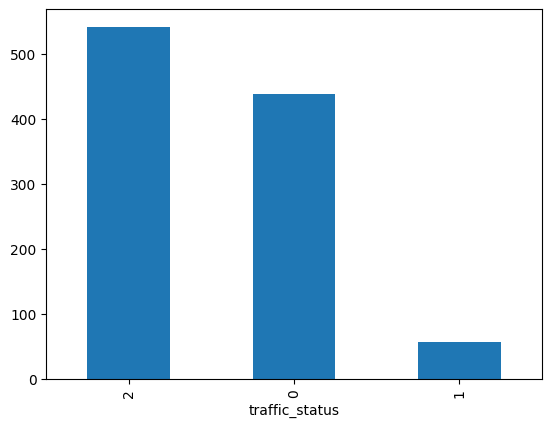

In [20]:
gdf['traffic_status'].value_counts().plot(kind='bar')
plt.show()

## Using RNN Model

### Building the RNN Model

In [21]:
# Define the RNN model
model_RNN = Sequential([
    SimpleRNN(units=32, return_sequences=False, input_shape=(time_steps, X_train_reshaped.shape[-1])),
    Dense(units=3, activation='softmax')
])

# Compile the model
model_RNN.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
model_RNN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 32)                  │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,443 (5.64 KB)

 Trainable params: 1,443 (5.64 KB)

 Non-trainable params: 0 (0.00 B)

### Fit the RNN Model

In [23]:
RNN_History = model_RNN.fit(X_train_reshaped, y_train, epochs=20, validation_data=(X_val_reshaped, y_val))
                            # ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.3435 - loss: 1.1027 - val_accuracy: 0.4774 - val_loss: 0.8267
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5036 - loss: 0.7986 - val_accuracy: 0.5097 - val_loss: 0.7517
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4864 - loss: 0.7438 - val_accuracy: 0.4774 - val_loss: 0.7279
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4905 - loss: 0.7197 - val_accuracy: 0.5161 - val_loss: 0.7188
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5180 - loss: 0.7051 - val_accuracy: 0.5355 - val_loss: 0.7126
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4864 - loss: 0.7131 - val_accuracy: 0.5290 - val_loss: 0.7098
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5303 - loss: 0.7027 - val_accuracy: 0.4581 - val_loss: 0.7084
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5261 - loss: 0.6955 - val_accuracy: 0.5226 - val_los

### Make preductuion RNN Model

In [24]:
pred_RNN = model_RNN.predict(X_test_reshaped)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


### Make Evaluation RNN Model

In [25]:
model_RNN.evaluate(X_test_reshaped, y_test)

# Get predicted classes from the model
pred_RNN_classes = np.argmax(pred_RNN, axis=1)

# Ensure y_test classes are match with pred_RNN_classes
y_test_converted = np.where(y_test == 0.5, 2, y_test)  # Change 0.5 to 2
y_test_converted = np.where(y_test_converted == 0, 0, 1)  # Change everything else to 1

# Calculate accuracy
RNN_accuracy = accuracy_score(y_test_converted, pred_RNN_classes)
print(f"RNN Accuracy: {100 * RNN_accuracy:.2f}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6271 - loss: 0.6725 
RNN Accuracy: 61.54%


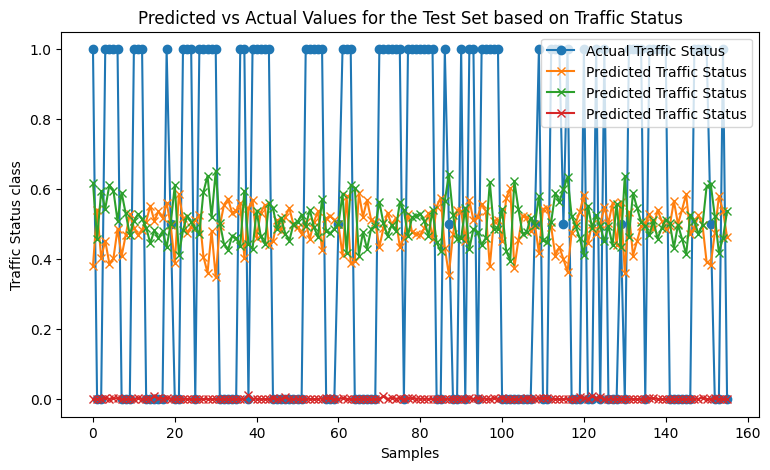

In [26]:
plt.figure(figsize=(9, 5))

plt.plot(y_test, label='Actual Traffic Status', marker='o')
plt.plot(pred_RNN, label='Predicted Traffic Status', marker='x')
plt.title('Predicted vs Actual Values for the Test Set based on Traffic Status')
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Traffic Status class')
plt.show()

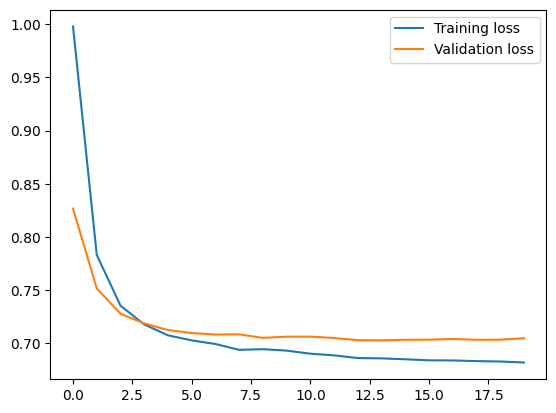

In [27]:
plt.plot(RNN_History.history['loss'], label='Training loss')
plt.plot(RNN_History.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [28]:
# #save model
model_RNN.save('model_RNN.keras')

## Using LSTM Model

### Building the LSTM Model

In [29]:
model_LSTM = Sequential([
    LSTM(units=64, return_sequences=False, input_shape=(time_steps, X_train_reshaped.shape[-1])),
    # LSTM(units=32, return_sequences=False),
    Dense(units=3, activation='softmax')
])

# Compile the model
model_LSTM.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [30]:
model_LSTM.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          18,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,139 (74.76 KB)

 Trainable params: 19,139 (74.76 KB)

 Non-trainable params: 0 (0.00 B)

### Fit the LSTM Model

In [31]:
history_LSTM = model_LSTM.fit(X_train_reshaped, y_train, epochs=20, validation_data=(X_val_reshaped, y_val))
                            # ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.3481 - loss: 1.0598 - val_accuracy: 0.5290 - val_loss: 0.9044
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5235 - loss: 0.8698 - val_accuracy: 0.5290 - val_loss: 0.7661
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5599 - loss: 0.7510 - val_accuracy: 0.5290 - val_loss: 0.7175
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4620 - loss: 0.7149 - val_accuracy: 0.5290 - val_loss: 0.7041
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5298 - loss: 0.7005 - val_accuracy: 0.5290 - val_loss: 0.6997
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4784 - loss: 0.7003 - val_accuracy: 0.5290 - val_loss: 0.6985
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5515 - loss: 0.6937 - val_accuracy: 0.4452 - val_loss: 0.6994
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5191 - loss: 0.6935 - val_accuracy: 0.5355 - val_loss

### Make preductuion LSTM Model

In [32]:
pred_LSTM = model_LSTM.predict(X_test_reshaped)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


### Make Evaluation LSTM Model

In [33]:
model_LSTM.evaluate(X_test_reshaped, y_test)

pred_LSTM_classes = np.argmax(pred_LSTM, axis=1)

# Ensure y_test classes are match with pred_RNN_classes
y_test_converted = np.where(y_test == 0.5, 2, y_test)  # Change 0.5 to 2

# Calculate accuracy
LSTM_accuracy = accuracy_score(y_test_converted, pred_LSTM_classes)
print(f"LSTM Accuracy: {100 * LSTM_accuracy:.2f}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5536 - loss: 0.6820 
LSTM Accuracy: 53.85%


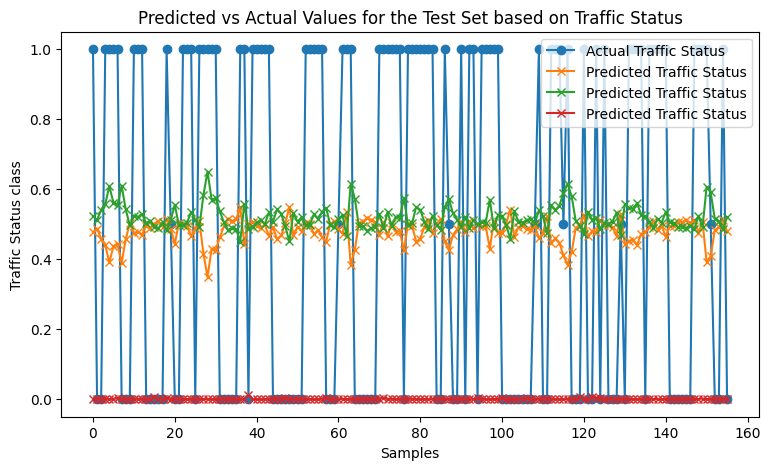

In [34]:
plt.figure(figsize=(9, 5))

plt.plot(y_test, label='Actual Traffic Status', marker='o')
plt.plot(pred_LSTM, label='Predicted Traffic Status', marker='x')
plt.title('Predicted vs Actual Values for the Test Set based on Traffic Status')
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Traffic Status class')
plt.show()

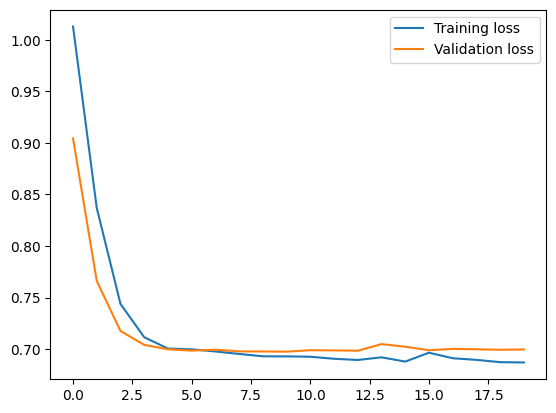

In [35]:
plt.plot(history_LSTM.history['loss'], label='Training loss')
plt.plot(history_LSTM.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [36]:
# #save model
model_LSTM.save('model_LSTM.keras')

## Using GRU Model

### Building the GRU Model

In [37]:
# Define the model
model_GRU = Sequential([
    GRU(units=32, return_sequences=False, input_shape=(time_steps, X_train_reshaped.shape[-1])),
    Dense(units=3, activation='softmax')
])

# Compile the model
model_GRU.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [38]:
model_GRU.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,227 (16.51 KB)

 Trainable params: 4,227 (16.51 KB)

 Non-trainable params: 0 (0.00 B)

### fit the GRU model

In [39]:
history_GRU = model_GRU.fit(X_train_reshaped, y_train, epochs=20, validation_data=(X_val_reshaped, y_val))
                            # ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.4770 - loss: 0.9783 - val_accuracy: 0.3742 - val_loss: 0.8609
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4908 - loss: 0.8305 - val_accuracy: 0.4903 - val_loss: 0.7718
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4825 - loss: 0.7548 - val_accuracy: 0.4968 - val_loss: 0.7320
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5004 - loss: 0.7206 - val_accuracy: 0.5613 - val_loss: 0.7150
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5080 - loss: 0.7074 - val_accuracy: 0.5613 - val_loss: 0.7081
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5207 - loss: 0.7007 - val_accuracy: 0.4194 - val_loss: 0.7057
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5459 - loss: 0.6945 - val_accuracy: 0.5419 - val_loss: 0.7028
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5530 - loss: 0.6928 - val_accuracy: 0.4645 - val_loss

### Make preductuion with Model GRU

In [40]:
pred_GRU = model_GRU.predict(X_test_reshaped)

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


### Make Evaluation GRU Model

In [41]:
model_GRU.evaluate(X_test_reshaped, y_test)

# Get predicted classes from the model
pred_GRU_classes = np.argmax(pred_GRU, axis=1)

# Ensure y_test classes are match with pred_RNN_classes
y_test_converted = np.where(y_test == 0.5, 2, y_test)  # Change 0.5 to 2
y_test_converted = np.where(y_test_converted == 0, 0, 1)  # Change everything else to 1

# Calculate accuracy
GRU_accuracy = accuracy_score(y_test_converted, pred_GRU_classes)
print(f"GRU Accuracy: {100 * GRU_accuracy:.2f}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5969 - loss: 0.6787 
GRU Accuracy: 58.97%


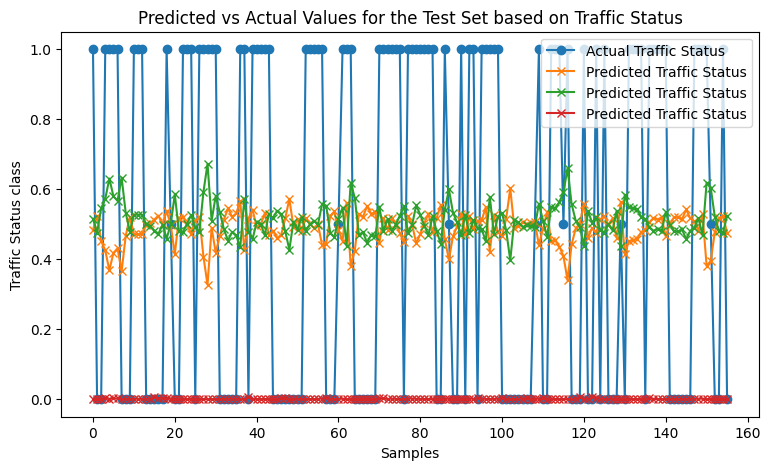

In [42]:
plt.figure(figsize=(9, 5))
plt.plot(y_test, label='Actual Traffic Status', marker='o')
plt.plot(pred_GRU, label='Predicted Traffic Status', marker='x')
plt.title('Predicted vs Actual Values for the Test Set based on Traffic Status')
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Traffic Status class')
plt.show()

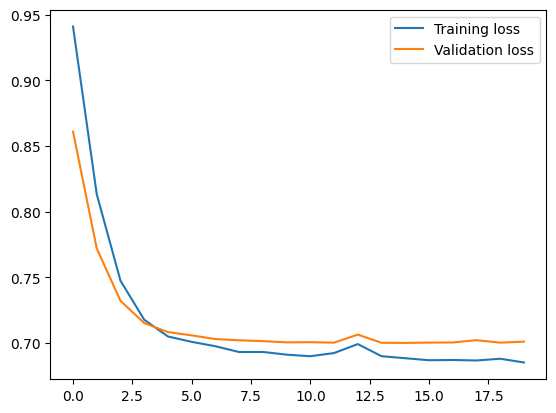

In [43]:
plt.plot(history_GRU.history['loss'], label='Training loss')
plt.plot(history_GRU.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

In [44]:
# #save model
model_GRU.save('model_GRU.keras')

##Generate Data for July Month

In [80]:
gdf_g = gdf.copy()
gdf_g = gdf_g.reset_index()

gdf_g = gdf_g.sample(frac=1) # shuffles the gdf_g in a random order.
gdf_g = gdf_g.loc[737:503] # Take random 168 Row -> How Take it ? gdf_g.tail(168)

# Create the full date range from 2023-07-01 to 2023-07-30
full_time_series = pd.date_range('2023-07-01 06:00:00', '2023-07-30 19:00:00', freq='h')

# Filter to include only hours from 6 AM to 7 PM
filtered_time_series = full_time_series[(full_time_series.hour >= 6) & (full_time_series.hour <= 19)]

# Randomly sample 168 timestamps -> Accident Numbers of 1 month
random_time_series = np.random.choice(filtered_time_series, size=168, replace=False)

# set new time_series for July Month
gdf_g['time_series'] = random_time_series

gdf_g = gdf_g.set_index('time_series')

gdf_g['traffic_status'] = np.nan # Replace empty strings with NaN
gdf_g['traffic_status'] = gdf_g['traffic_status'].astype(float) # Convert to float

gdf_g.sort_index(inplace=True)
gdf_g

,number_of_cars_involved,accident_reason,number_of_injured,number_of_cars,average_car_speed,latitude_x,longitude_x,latitude_y,longitude_y,traffic_status
time_series,,,,,,,,,,
2023-07-01 07:00:00,2,1,0,44,47.91,46.793509,24.733968,46.793570,24.734006,NaN
2023-07-01 08:00:00,2,1,0,109,12.17,46.778837,24.725391,46.777662,24.724658,NaN
2023-07-01 10:00:00,5,1,1,48,61.80,46.863861,24.794850,46.863125,24.793862,NaN
2023-07-01 14:00:00,3,1,0,62,58.51,46.767111,24.718116,46.766506,24.717741,NaN
2023-07-01 15:00:00,2,1,0,25,35.32,46.679757,24.675866,46.679146,24.675740,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-07-30 07:00:00,2,2,0,20,36.60,46.785246,24.728807,46.785786,24.729144,NaN
2023-07-30 09:00:00,2,1,0,78,14.96,46.845280,24.769452,46.845690,24.770003,NaN
2023-07-30 11:00:00,2,0,0,103,32.40,46.618923,24.665510,46.619393,24.665754,NaN


In [81]:
sc = MinMaxScaler()

sc_data = sc.fit_transform(gdf_g[['latitude_x', 'longitude_x', 'latitude_y', 'longitude_y']])

scaler = MinMaxScaler()

# Now to unscale the data
scaled_data = scaler.fit_transform(gdf_g)

# Convert the DataFrame to a NumPy array
gdf_g_array = scaled_data[:, :-1]

# Reshape the array to match the expected input shape for the LSTM model
# The timesteps should match the model definition, likely 1 timestep with 9 features
gdf_g_reshaped = gdf_g_array.reshape(gdf_g_array.shape[0], 1, 9)

# Make the prediction using the reshaped array
pred_RNN_July = model_RNN.predict(gdf_g_reshaped)

# Get prediction classes
pred_RNN_July_classes = np.argmax(pred_RNN_July, axis=1) # Class distribution in y before splitting: { Heavy 0.0: 439, Light 0.5 -> 2: 56, Moderate 1.0: 541}

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:695: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:712: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


Note: if error appear check Generate Data for July Month code it is randomaize every time code run, line: shuffles the gdf_g in a random order.

## Draw The Predicted Values in Riyadh Map

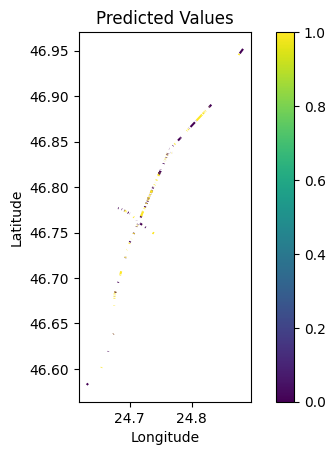

In [84]:
# unscale the 'latitude_x', 'longitude_x', 'latitude_y', 'longitude_y'
unscaled_data = sc.inverse_transform(sc_data)

# Create a DataFrame with combined data for two predicted values
results_df = pd.DataFrame({
    'timestamp': gdf_g.index,
    'traffic_status': pred_RNN_July_classes,
    'latitude_x': gdf_g['latitude_x'],  # Replace with correct latitudes
    'longitude_x': gdf_g['longitude_x'],  # Replace with correct longitudes
    'latitude_y': gdf_g['latitude_y'],  # Replace with correct latitudes
    'longitude_y': gdf_g['longitude_y']  # Replace with correct longitudes
})


# Create LINESTRING geometries
geometry = [LineString(zip([lon_x, lon_y], [lat_x, lat_y]))
            for lon_x, lat_x, lon_y, lat_y in zip(
                results_df['longitude_x'],
                results_df['latitude_x'],
                results_df['longitude_y'],
                results_df['latitude_y']
            )]

gdf_result = gpd.GeoDataFrame(results_df, geometry=geometry)
gdf_result.crs = "EPSG:4326"  # Set the coordinate reference system (CRS)

# Plot the GeoDataFrame
gdf_result.plot(column='traffic_status', legend=True, cmap='viridis', markersize=100)
plt.title('Predicted Values')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

###Display Map For July month ( Prediction )

In [85]:
#Folium map centered at Riyadh
riyadh_coords = [24.7136, 46.6753]  # Riyadh's latitude and longitude
m = folium.Map(location=riyadh_coords, zoom_start=10)

# Add lines for each LINESTRING with color based on traffic status
for _, row in gdf_result.iterrows():
    # Get the traffic status value and handle potential out-of-range values
    traffic_status_value = row['traffic_status']

    # Check if the value is within the valid range
    if traffic_status_value == 2:
        color = 'green'
    elif traffic_status_value == 0:
        color = 'red'
    elif traffic_status_value == 1:
        color = 'blue'
    else:
        color = 'gray'  # or handle it differently

    # Get coordinates for the LINESTRING
    line_coords = list(row['geometry'].coords)  # Access the 'geometry' column for LINESTRING coordinates

    # Create a PolyLine for the LINESTRING
    folium.PolyLine(
        locations=line_coords,  # Use line coordinates
        color=color,  # Use the determined color
        weight=5,  # Adjust line weight as needed
        popup=f"Traffic Status: {color}"
    ).add_to(m)

# 4. Add a legend to the map
legend_html = """
    <div style="position: fixed;
                bottom: 50px; left: 50px; width: 150px; height: 90px;
                border:2px solid grey; z-index:9999; font-size:14px;
                background-color:white;
                ">
        &nbsp; <b>Traffic Status July</b> <br>
        &nbsp; <i class="fa fa-circle fa-1x" style="color:green"></i>&nbsp; Light <br>
        &nbsp; <i class="fa fa-circle fa-1x" style="color:red"></i>&nbsp; Heavy <br>
        &nbsp; <i class="fa fa-circle fa-1x" style="color:blue"></i>&nbsp; Moderate
    </div>
    """
m.get_root().html.add_child(folium.Element(legend_html))

# 5. Display the map
m

## Data For all preiod time ( Real & Predction )

In [86]:
for i in gdf_result.columns:
    if i != 'geometry' and i != 'traffic_status':
      gdf_result.drop(i,axis=1,inplace=True)

gdf_Merge_Traffic_Status = pd.concat([gdf_map, gdf_result], axis=0)
gdf_Merge_Traffic_Status.index.sort_values()

# Convert DataFrame To GeoDataFrame
gdf_Merge_Traffic_Status = gpd.GeoDataFrame(gdf_Merge_Traffic_Status, geometry=gdf_Merge_Traffic_Status['geometry'])
gdf_Merge_Traffic_Status.crs = "EPSG:4326"  # Set the coordinate reference system (CRS)

# Sort index Values
gdf_Merge_Traffic_Status.reset_index(inplace=True)
gdf_Merge_Traffic_Status.sort_values(by='time_series', inplace=True)
gdf_Merge_Traffic_Status.set_index('time_series', inplace=True)

# Show data
gdf_Merge_Traffic_Status

,traffic_status,geometry
time_series,,
2023-01-01 06:00:00,1,"LINESTRING (46.81213 24.7455, 46.81236 24.74565)"
2023-01-01 11:00:00,2,"LINESTRING (46.79363 24.73404, 46.79412 24.73434)"
2023-01-01 14:00:00,0,"LINESTRING (46.78266 24.72777, 46.7817 24.72718)"
2023-01-01 16:00:00,0,"LINESTRING (46.86313 24.79386, 46.86064 24.79053)"
2023-01-02 06:00:00,1,"LINESTRING (46.97912 24.90795, 46.98097 24.909..."
...,...,...
2023-07-30 07:00:00,1,"LINESTRING (24.72881 46.78525, 24.72914 46.78579)"
2023-07-30 09:00:00,0,"LINESTRING (24.76945 46.84528, 24.77 46.84569)"
2023-07-30 11:00:00,0,"LINESTRING (24.66551 46.61892, 24.66575 46.61939)"


####Was There a problem with ['traffic_status'] == Moderate in geometry, I have updated it

In [87]:
moderate_lines = gdf[gdf['traffic_status'] == 2]

# Create LINESTRING geometries using only moderate_lines DataFrame
geometry = [LineString(zip([lon_x, lon_y], [lat_x, lat_y]))
            for lon_x, lat_x, lon_y, lat_y in zip(
                moderate_lines['longitude_x'], #Use moderate_lines instead of gdf
                moderate_lines['latitude_x'], #Use moderate_lines instead of gdf
                moderate_lines['longitude_y'], #Use moderate_lines instead of gdf
                moderate_lines['latitude_y']  #Use moderate_lines instead of gdf
            )]

gdf_uu = gpd.GeoDataFrame(moderate_lines, geometry=geometry)
gdf_uu.crs = "EPSG:4326"  # Set the coordinate reference system (CRS)

for i in gdf_uu.columns:
    if i != 'geometry' and i != 'traffic_status':
      gdf_uu.drop(i,axis=1,inplace=True)

# Update the geometry in gdf_Merge_Traffic_Status where traffic_status is 2
gdf_Merge_Traffic_Status.loc[gdf_Merge_Traffic_Status['traffic_status'] == 2, 'geometry'] = \
    gdf_uu.loc[gdf_uu['traffic_status'] == 2, 'geometry'].values

# Optional: Set CRS if necessary (only if gdf_uu does not have a CRS)
gdf_Merge_Traffic_Status.set_crs(epsg=4326, inplace=True)  # Adjust EPSG code as needed

,traffic_status,geometry
time_series,,
2023-01-01 06:00:00,1,"LINESTRING (46.81213 24.7455, 46.81236 24.74565)"
2023-01-01 11:00:00,2,"LINESTRING (24.73404 46.79363, 24.73434 46.79412)"
2023-01-01 14:00:00,0,"LINESTRING (46.78266 24.72777, 46.7817 24.72718)"
2023-01-01 16:00:00,0,"LINESTRING (46.86313 24.79386, 46.86064 24.79053)"
2023-01-02 06:00:00,1,"LINESTRING (46.97912 24.90795, 46.98097 24.909..."
...,...,...
2023-07-30 07:00:00,1,"LINESTRING (24.72881 46.78525, 24.72914 46.78579)"
2023-07-30 09:00:00,0,"LINESTRING (24.76945 46.84528, 24.77 46.84569)"
2023-07-30 11:00:00,0,"LINESTRING (24.66551 46.61892, 24.66575 46.61939)"


#### save gdf_Merge_Traffic_Status


In [88]:
# save gdf_Merge_Traffic_Status
gdf_Merge_Traffic_Status.to_csv('gdf_Merge_Traffic_Status.csv')
# Use to_file to save as GeoPackage
gdf_Merge_Traffic_Status.to_file('gdf_Merge_Traffic_Status.gpkg', driver='GPKG')
gdf_Merge_Traffic_Status.to_file('gdf_Merge_Traffic_Status.geojson', driver='GeoJSON')

###Display Map For all preiod time ( Real & Predction )

In [89]:
#Folium map centered at Riyadh
riyadh_coords = [24.7136, 46.6753]  # Riyadh's latitude and longitude
m = folium.Map(location=riyadh_coords, zoom_start=10)

# Add lines for each LINESTRING with color based on traffic status
for _, row in gdf_Merge_Traffic_Status.iterrows():
    # Get the traffic status value and handle potential out-of-range values
    traffic_status_value = row['traffic_status']

    # Check if the value is within the valid range
    if traffic_status_value == 2:
        color = 'green'
    elif traffic_status_value == 0:
        color = 'red'
    elif traffic_status_value == 1:
        color = 'blue'
    else:
        color = 'gray'  # or handle it differently

    # Get coordinates for the LINESTRING
    line_coords = list(row['geometry'].coords)  # Access the 'geometry' column for LINESTRING coordinates

    # Create a PolyLine for the LINESTRING
    folium.PolyLine(
        locations=line_coords,  # Use line coordinates
        color=color,  # Use the determined color
        weight=5,  # Adjust line weight as needed
        popup=f"Traffic Status: {color}"
    ).add_to(m)
# 4. Add a legend to the map
legend_html = """
    <div style="position: fixed;
                bottom: 50px; left: 50px; width: 150px; height: 90px;
                border:2px solid grey; z-index:9999; font-size:14px;
                background-color:white;
                ">
        &nbsp; <b>Traffic Status All</b> <br>
        &nbsp; <i class="fa fa-circle fa-1x" style="color:green"></i>&nbsp; Light <br>
        &nbsp; <i class="fa fa-circle fa-1x" style="color:red"></i>&nbsp; Heavy <br>
        &nbsp; <i class="fa fa-circle fa-1x" style="color:blue"></i>&nbsp; Moderate
    </div>
    """
m.get_root().html.add_child(folium.Element(legend_html))

# 5. Display the map
m